<a target="_blank" href="https://colab.research.google.com/github/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2017%20-%20Convolutional%20NN%20with%20PyTorch/Lecture%2017%20-%20Convolutional%20NN%20with%20PyTorch.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a name='section0'></a>
# Lecture 17 Convolutional Neural Networks with PyTorch

- [17.1 Introduction to PyTorch](#section1)
- [17.2 Training Neural Networks](#section2)
- [17.3 Loading the Dataset](#section3)
- [17.4 Creating, Training, and Evaluating the Model](#section4)
- [17.5 Using a Custom Dataset and a Pretrained Model](#section5)
- [17.6 Model Saving and Loading in PyTorch](#section6)
- [References](#section7)

<a name='section1'></a>

# 17.1 Introduction to PyTorch

***PyTorch*** is currently one of the most popular deep learning frameworks. It is an open-source library built upon the Torch library, and it was developed by Meta AI (previously Facebook AI). It is now part of the Linux Foundation. 

As we learned in the tutorial, PyTorch provides tensor operations that can conveniently be performed using CPU or GPU devices. It also provides automatic differentiation operations (auotgrad) with artificial neural networks.

In this lecture we will explain how to train Convolutional Neural Networks for image classification with PyTorch. PyTorch has similar functionality to Keras and TensorFlow, as it allows to import neural network layers, offers loss functions and optimizers, etc. It has a slightly lower-level of abstraction in comparison to Keras. On the other hand, there are high-level libraries for PyTorch, such as [PyTorch Lightning](https://www.pytorchlightning.ai/) and [fast.ai](https://www.fast.ai/). 

First, let's provide an explanation of the training process of ConvNets, as it will be helpful to understand the PyTorch code. 

<a name='section2'></a>

# 17.2 Training Neural Networks

Training neural networks is performed by iterative updates of the model parameters with the goal to minimize the difference between the model predictions and target labels.

Each iteration in the training phase includes the following 4 steps:
1. Forward pass (forward propagation)
2. Loss calculation 
3. Error backpropagation (backward pass)
4. Model parameters update

***Forward propagation*** is also known as ***forward pass***, because the input data is passed through all hidden layers of the neural network toward the output layer to obtain the network predictions. If the input data is an image, the image is transformed through the layers of the network, and for classification problems, the output is a vector of predicted class probabilities. 

***Loss calculation*** is the second step, in which the loss of the network is calculated as a difference between the network output (predictions for each class) and the target label (ground-truth) for the image. As we mentioned, standard loss function for classification tasks is crossentropy loss, calculated as $-\sum{y\cdot log(\hat{y})}$, where $y$ is the ground-truth label and $\hat{y}$ is the model prediction. For regression tasks commonly used loss functions include mean-squared deviation, mean absolution deviation, and root-mean-squared deviation between the network predictions and target values. The goal of the model training becomes to minimize the obtained loss score.

***Error backpropagation*** is also called ***backward pass*** or ***backward propagation*** (the term backpropagation is short for backward propagation). In this step, the predicted outputs are traversed back through the network, from the last layer backward toward the first layer. During the backward step, the gradients of the loss with respect to the model parameters $\nabla\mathcal{L}(𝜃)$ are calculated. If you recall from calculus, ***gradient*** is the vector of partial derivatives of a function, or for a loss function $\mathcal{L}$ and network parameters $𝜃$, the gradient is the vector $\nabla\mathcal{L} = [\partial\mathcal{L}/\partial𝜃_i]$. The gradients quantify the impact of changing the parameters in the network to the predicted outputs. Automatic calculation of the gradients (automatic differentiation) is available in all current deep learning libraries, which significantly simplifies the implementation of deep learning algorithms. 

***Model parameters update*** is the last step in which new values for the model parameters are calculated and updated, typically using the ***Gradient Descent*** algorithm.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2017%20-%20Convolutional%20NN%20with%20PyTorch/images/forward_backward.png' width=800px/>

A simple depiction of the ***Gradient Descent*** algorithm is shown in the next figure. The blue curve is a loss function, and the gradient of the loss function gives the slope of the function. By updating the parameters in the opposite direction of the gradient of the loss $\nabla\mathcal{L}$, the algorithm finds parameters $𝜃$ for which the loss $\mathcal{L}$ has a minimal value. 

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2017%20-%20Convolutional%20NN%20with%20PyTorch/images/gradient_descent.png' width=600px/>

Almost all modern neural networks are trained by applying a modified version of the Gradient Descent algorithm. Examples of such advanced Gradient Descent algorithms include Adam, SGD (Stochastic Gradient Descent), RMSprop, Adagrad, Nadam, and others. The deep learning libraries typically refer to the used algorithms for minimizing the loss of the model as ***optimizers***.

And, to train a neural network, the above steps of forward pass, loss calculation, backward pass, and parameter update are performed iteratively for each batch of input data. This is shown in the following simple pseudocode. 

```
for epoch in number_of_epochs:
    for batch in number_of_batches:
        forward pass
        calculate loss
        backward pass (calculate the gradients)
        update parameters
 ```
 
Unlike the model training, predicting on test data (also known as *inference*) requires only a forward pass through the model, where for a given input instance the model outputs the predicted vector of class probabilities. 

<a name='section3'></a>

# 17.3 Loading the Dataset

We will use one of the most common deep learning datasets - MNIST (Modified National Institute of Standards and Technology database). MNIST is a dataset of handwritten digits from 0 to 9, containing 60,000 training images and 10,000 testing images. Each image has 28x28 pixels size.

PyTorch provides access to several datasets, and MNIST can be loaded conveniently by using the `datasets.MNIST` function. In the used arguments, `root` is the directory where the dataset exists, and `transform` can be used to apply data scaling, image resizing, or other transformation operations. Such operations are not required for this dataset.

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# trochvision is part of PyTorch consisting of models and datasets for computer vision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


The images in MNIST are gray images, and therefore, they have only one channel, differently from RGB images which have 3 channels. Recall that `size()` in PyTorch corresponds to `shape` in NumPy.

In [ ]:
print(training_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


Let's visualize several randomly selected images from the training dataset, and show their class labels.

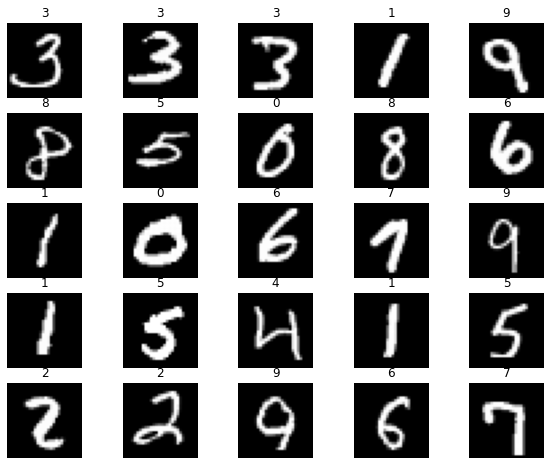

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### DataLoader

In PyTorch, `DataLoader` is an iterable object used for passing a batch of input data at each iteration during the model training. It takes as arguments the dataset that we are going to use, `shuffle` indicates if the data should be shuffled, and `batch_size` is self-explanatory. While we always need to shuffle the data in the training dataset to avoid correlated data (e.g., the training dataset can have first all 0 images, then 1 images, etc.), we don't need to shuffle the test or validation datasets because they are not used for training.

In [ ]:
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=128)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=128)

The output of DataLoader is a batch of input images and the corresponding target labels. To inspect a batch of data we need to use the `iter` method to obtain an iterator, and afterward we can use the `__next__()` method (or simply `next()`) to iterate over the batches. Note that the DatLoader converted the images into a format (1,28,28) where 1 is the number of channels of the images.

In [ ]:
iter(train_dataloader) is train_dataloader

False

In [ ]:
# Inspect a batch of images and labels
batch_images, batch_labels = iter(train_dataloader).next()
print("Batch images shape:", batch_images.size())
print("Batch labels shape:", batch_labels.size())

Batch images shape: torch.Size([128, 1, 28, 28])
Batch labels shape: torch.Size([128])


<a name='section4'></a>

# 17.4 Creating, Training, and Evaluating the Model

### Model Definition

We will define a Convolution Neural Network using the `nn.Module` in PyTorch, which is as a superclass for creating neural network models in PyTorch. I.e., the CNN model will represent a subclass of the superclass `nn.Module`.

In the `__init__()` constructor method of the CNN class, we will list the layers of the model as attributes of the class. For this task, let's use 2 convolutional layers that we will name `conv1` and `conv2`, a max-pooling layer, ReLU layer, and a dense layer. `nn.Module` also has several attributes which we will inherit via `super(CNN, self).__init__()`.

***Conv2d layers*** in PyTorch have similar arguments as the Keras library, as follows:
- *in_channels* (int), number of input channels to the layer, which is the number of channels in input images for the first layer, and the number of output channels from the preceding layer for all other layers (this argument is not provided in the Keras layers, it is determined automatically).
- *out_channels* (int), number of channels that are produced by the layer (i.e., the number of used convolutional filters).
- *kernel_size* (int or tuple), size of the convolving kernel (it is typically 3, and sometimes can also be 5, 7, etc.).
- *padding* (int or tuple, optional), padding can be added to both sides of the input images; default value is 0, i.e., no padding.

Note that applying a convolutional filter to an image results in a convolved image with a reduced size. To obtain a resulting feature map of the same size as the original image, padding is applied. For instance, in the figure below, a filter with a kernel size 3x3 is applied to a padded image of size 7x7, and the output is a feature with size 5x5. In this case, the original image of size 5x5 is padded with zeros on all four sides, and the size was changed to 7x7. This is a padding=1, because on all sides one row or column is added.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2017%20-%20Convolutional%20NN%20with%20PyTorch/images/padding.png' width=700px/>

***Max pooling layers*** are defined the same as in Keras, and have as argument the kernel size for the pooling operation.

The outputs of convolutional layers are passed through a ***ReLU activation layer***. ReLU stands for **Re**ctified **L**inear **U**nit activation function. Activation functions introduce non-linearity to the layers in the model, which allows to learn complex relations between the inputs and outputs. There are several different activation functions used with neural networks, and they include sigmoid, tanh, ReLU, Leaky ReLU, and others. Most modern neural networks apply ReLU activation function, or some variants of it.

The ReLU function is shown in the next figure, and it simply outputs 0 if the input is negative, or outputs the input if it is positive. 

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2017%20-%20Convolutional%20NN%20with%20PyTorch/images/relu.png' width=400px/>

***Dense (fully-connected) layers*** in PyTorch are defined with the `nn.Linear` module, and they have as arguments:
- *in_features* (int), number of input features to the layer (this argument is not provided in the Keras Dense layer, it is determined automatically).
- *out_features* (int), number of output features of the layer.

After we define the layers in the model, we will add the method `forward` to define the forward pass for the model. For this model, we will use 2 blocks of convolutional, ReLU, and max-pooling layers, and a final dense layer to make the predictions. Also recall that in the previous lecture we used the Flatten layer to convert the image tensors into one-dimensional vectors. Here, we use `torch.flatten()` to flatten the tensors.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # maxpooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)  

        # ReLU activation layer
        self.relu = nn.ReLU()

        # fully connected layer, output 10 classes
        self.dense = nn.Linear(in_features=32 * 7 * 7, out_features=10)
    
    def forward(self, x):
        # sequence of layers
        # first block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # second block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # flatten the output of the second block to 1D vector
        x = torch.flatten(x, 1)

        # output layer      
        output = self.dense(x)
        
        return output    

Next, we will create an instance of the model, here named `cnn_model`.

In [ ]:
cnn_model = CNN()

We can use `torch.device` to check if GPU is available. I am using Google Colab, the device type is 'cuda', therefore, it is available. CUDA (Compute Unified Device Architecture) is a library that allows using GPU computing for machine learning tasks, which parallelizes the computations, and speeds up the model training. 

PyTorch will by defult use GPU if it is available, and otherwise it will use CPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Using `to(device)` will transfer the ConvNet model to the device, which in our case is GPU. 

In [ ]:
cnn_model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dense): Linear(in_features=1568, out_features=10, bias=True)
)

### Model Training

Before training the model, we need to define a loss function and an optimizer. As we mentioned in the previous lecture, crossentropy loss is commonly used with classification problems, and Adam is standardly used optimization algorithm. 

In [ ]:
# define loss function (cross-entropy)
criterion = nn.CrossEntropyLoss()   
# define an optimizer (Adam)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.01)  

The following cell trains the model, and it is similar to the `fit` function in scikit-learn or Keras. It contains a for-loop over the epochs, and afterwards the variables `running_loss`, `total`, and `sum_correct` are initialized and will be used to record and display the training loss and accuracy. Next, a batch of images is loaded, and the above four steps are performed: forward pass, loss calculation, backward pass, and parameters update. The remaining lines calculate the loss and accuracy and display their values after each epoch. The `item()` method is used to convert the tensors to NumPy floats and bring them to the CPU. PyTorch uses GPU for performing calculations, and CPU for displaying and plotting the variables.

In [ ]:
# total number of training epochs
epoch_num = 10

# loop over the number of epochs
for epoch in range(epoch_num):  

    # the loss values for each epoch 
    running_loss = 0.0
    # total images in each epoch
    total = 0
    # correctly predicted images in each epoch
    sum_correct = 0
   
    ### training 
    # loop over the batches in the training dataset
    for i, data in enumerate(train_dataloader):
        # get a batch of images and labels
        images, labels = data
        # send the images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # set the gradient to zero, to clear the values from the last iteration
        optimizer.zero_grad()

        # forward pass: propagate the inputs through the network to obtain output predictions
        outputs = cnn_model(images)
        # calculate the loss (crossentropy)
        loss = criterion(outputs, labels)
        # backward pass: propagate backward and calculate the gradients
        loss.backward()
        # update the model parameters (using the optimizer Adam)
        optimizer.step()

        # calculate the loss and accuracy for the current batch 
        # running loss is the average loss of the current batch
        # '.item()' returns the value of the PyTorch tensor as Python float32
        # and moves its value to the CPU
        running_loss += loss.item()
        # 'predicted' is the vector of class labels for images in the batch
        # this is similar to np.argmax
        _, predicted = torch.max(outputs.data, dim=1)
        # 'total' is the number of images (or labels) in the batch
        total += labels.size(0)
        # correct is the number of correctly predicted images in the batch
        sum_correct += (predicted==labels).sum().item()
    
    # calculate the accuracy for each epoch
    accuracy = sum_correct/total

    # print the epoch number, training loss, and training accuracy
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {running_loss:.3f}\t',
              f'\t Training accuracy: {100*accuracy:2.3f}')

Epoch: 1/10	 Training loss: 68.262	 	 Training accuracy: 95.583
Epoch: 2/10	 Training loss: 24.808	 	 Training accuracy: 98.375
Epoch: 3/10	 Training loss: 20.139	 	 Training accuracy: 98.668
Epoch: 4/10	 Training loss: 16.479	 	 Training accuracy: 98.907
Epoch: 5/10	 Training loss: 14.567	 	 Training accuracy: 98.963
Epoch: 6/10	 Training loss: 12.266	 	 Training accuracy: 99.172
Epoch: 7/10	 Training loss: 12.859	 	 Training accuracy: 99.100
Epoch: 8/10	 Training loss: 11.923	 	 Training accuracy: 99.188
Epoch: 9/10	 Training loss: 10.604	 	 Training accuracy: 99.272
Epoch: 10/10	 Training loss: 10.796	 	 Training accuracy: 99.292


### Model Evaluation

The following cell evaluates the accuracy on the test dataset. For this step, we will use `with torch.no_grad()` context manager, to indicate that there is no need to calculate the gradients, since the model parameters are not updated. Also, only the forward pass is required for evaluation on test images. 

In [ ]:
### testing

# these variables are similar to the variables for the training phase     
test_running_loss = 0.0
test_total = 0
test_correct = 0

# torch.no_grad() specify not to update the model during testing
with torch.no_grad():
  # loop over the batches in the test dataset
  for i, data in enumerate(test_dataloader):
      # get a batch of images and labels
      images, labels = data
      # send the images and labels to the GPU
      images, labels = images.to(device), labels.to(device)
      
      # forward pass
      outputs = cnn_model(images)
      # calculate the loss
      loss = criterion(outputs, labels)
      # there is no backward pass in the testing step

      # these variables are the same as in the training setp
      test_running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()     

print(f'Accuracy of the model on the test images: {100*test_correct/test_total:2.3f}')

Accuracy of the model on the test images: 98.730


<a name='section5'></a>

# 17.5 Using a Custom Dataset and a Pretrained Model

### Loading the Dataset

In this section, we will look at one more classification task with CNN in PyTorch. We will use the GTSRB (German Traffic Sign Recognition Benchmark) dataset, which consists of 51,000 images of traffic signs. There are 43 classes of traffic signs, and the size of the images is 32×32 pixels.

Custom datasets in PyTorch are created as a subclass of the `Dataset` class, which is imported from `torch.utils.data`. The custom datasets should inherit from `Dataset` and override the following two methods:
- `__len__()`, to return the number of instances in the dataset.
- `__getitem__()` to support indexing and return the instances with the specified indices `idx` in the dataset.

In the cell below, we used `MyDataset` as the name of the subclass. For this case, the training, validation, and test datasets were saved with `pickle` as dictionaries containing pairs of images (called 'features') and targets (called 'labels'). In the `__init__()` method we will load the pickled data, and the other two methods will provide the length and return sets of images and labels with given indices. The images were already resized to the same size and they were scaled to the range [0,1], therefore applying transformation operations is not needed.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, filepath):
        with open(filepath, mode='rb') as f:
             dataset = pickle.load(f)
        
        self.transform = ToTensor()
        self.features = dataset['features']
        self.labels = dataset['labels'] 
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        feature = self.transform(feature)
        label = self.labels[idx]

        return feature, label

We need to mount the Google Drive, since the images are saved on the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


As in the above example, we will use DataLoader to iterate over batches of images and labels. 

In [ ]:
import pickle

train_dataset = MyDataset('drive/MyDrive/Data_Science_Course/Lecture_17-CNN_with_PyTorch/data/GTSRB_dataset/train.p')
test_dataset = MyDataset('drive/MyDrive/Data_Science_Course/Lecture_17-CNN_with_PyTorch/data/GTSRB_dataset/test.p')
validation_dataset = MyDataset('drive/MyDrive/Data_Science_Course/Lecture_17-CNN_with_PyTorch/data/GTSRB_dataset/valid.p')

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=False, batch_size=64)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(validation_dataset))

34799
12630
4410


PyTorch has a function `make_grid()` which allows to plot a grid of images.

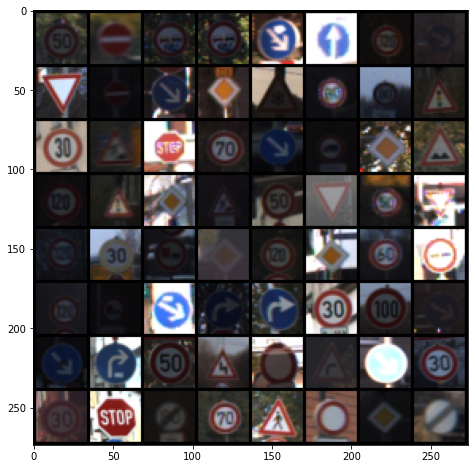

In [ ]:
# show several images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images and labels
images, labels = iter(train_dataloader).next()

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

### Model Loading

PyTorch has pretrained models that are easy to be loaded and used. Let's import a VGG model pretrained on the ImageNet.

In [ ]:
from torchvision.models import vgg16

#VGG16
vgg_model = vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


To use the VGG model with our dataset, we will change the last layer in the model (this is layer '6' in the classifier of the model) with a dense layer that will output 43 features, since there are 43 classes of signs in the dataset.

In [ ]:
# replace the last layer in VGG with a dense layer to predict 43 classes
vgg_model.classifier._modules['6'] = nn.Linear(4096, 43)

In [ ]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Modular Code: Training and Validation for One Epoch

For this example, let's write functions for training and validating the model. These functions will group all required code for training and validation, and we can re-use such modular code in other scripts. 

The functions are almost identical to the code that we used above. They return the accuracy and loss for the epoch. Note that we used the lines `model.train()` and `model.eval()` in these functions, which act as a switch for some specific layers that behave differently during training and evaluation. For example, Dropout and Batch Normalization layers are turned on during training and turned off during evaluation, which is controlled by these two lines. 

In [ ]:
# train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train() 

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
    
    # return the accuracy and loss
    return sum_correct/total, running_loss


# evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss

### Define Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

### Model Training

The next cell contains code for training the model. Now we can call the `train` and `validate` functions to perform the training and validation steps for each epoch. The outputs are the average accuracy and loss, calculated at the end of each epoch. We will append those values to lists, which we will use later to plot the learning curves. 

In [ ]:
# total number of training epochs
epoch_num = 6

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

# loop over the number of epochs
for epoch in range(epoch_num):  

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(vgg_model, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(vgg_model, validation_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)
    
    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

Epoch: 1/6	 Training loss: 489.022	 Training accuracy: 72.660	 Validation accuracy: 87.574
Epoch: 2/6	 Training loss: 57.492	 Training accuracy: 96.572	 Validation accuracy: 91.837
Epoch: 3/6	 Training loss: 21.848	 Training accuracy: 98.756	 Validation accuracy: 93.288
Epoch: 4/6	 Training loss: 10.666	 Training accuracy: 99.345	 Validation accuracy: 92.857
Epoch: 5/6	 Training loss: 9.813	 Training accuracy: 99.425	 Validation accuracy: 95.215
Epoch: 6/6	 Training loss: 6.200	 Training accuracy: 99.684	 Validation accuracy: 95.193


The training and validation accuracies and loss are shown in the next figure. Note that Mathplotlib doesn't support plotting tensors that are on the GPU, and therefore, we needed to bring the values of the accuracies and losses to the CPU for plotting (e.g., by using `item()` as in the above code).

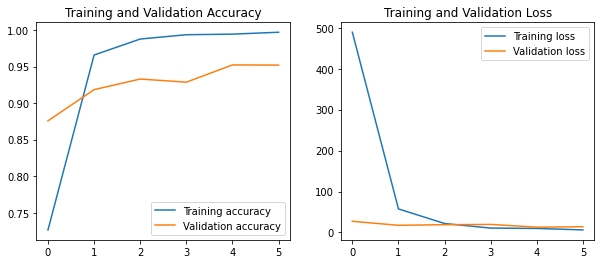

In [ ]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

### Model Evaluation

We can use the same function `validate` to evaluate the model performance on the test dataset.

In [ ]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(vgg_model, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 94.941


<a name='section6'></a>

# 17.6 Model Saving and Loading in PyTorch

### Save and Load State Dictionary

To save PyTorch models we use `torch.save()` as shown below. The parameters of the model are stored in a state dictionary with `state_dict()`, and as expected, the path to the directory to save the model needs to be provided. A `state_dict()` is a dictionary that has as keys the layers in the network, and the values in the dictionary are the corresponding parameters in each layer. 

A PyTorch convention is to use the extension `.pth` or `.pt` with the file path. 

In [ ]:
torch.save(vgg_model.state_dict(), 'vgg_model_weights.pth')

Let's print the keys in the `state_dict` for the vgg model. The model has 30 layers in the `features` part, and 6 layers in the `classifier` part (as shown in one of the above cells). E.g., `features.0.weight` is the key for the weights in layer 0 and `features.0.bias` is the key for the biases in layer 0 of the model, where biases is a vector of trainable constant values that are added to the weights in each layer.

In [ ]:
print("Keys in the state_dict keys: \n", vgg_model.state_dict().keys())

Keys in the state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


To load a saved model, we need to have an instance of the model, and therefore let's create an instance `model_1`. Then, we use the `load_state_dict()` method with `torch_load()`. Internally PyTroch uses pickle to serialize and deserialize the  `state_dict()` when saving and loading.

In [ ]:
model_1 = vgg_model

model_1.load_state_dict(torch.load('vgg_model_weights.pth'))

<All keys matched successfully>

In [ ]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(model_1, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 94.941


### Save and Load the Entire Model

Instead of saving only the model parameters with the `state_dict()`, it is also possible to save the entire model in PyTorch, including the class definition, the architecture with the layers, and other related information. However, this is not a recommended way to save the model, because loading the model in other projects may fail in various ways. 

In [ ]:
torch.save(vgg_model, 'vgg_model_2.pth')

### Save and Load a Checkpoint

If we would like to save the model checkpoint after an epoch, and later resume the training, we will need to also save information about the loss and gradients at that epoch, along with the state dictionary. In the next cell, the checkpoints saves the last epoch (epoch 6 in this case), the state dictionary `model.state_dict()`, and the optimizer information `optimizer.state_dict()`.

In [ ]:
checkpoint = {'epoch': epoch,
              'state_dict': vgg_model.state_dict(),
              'optimizer_state' : optimizer.state_dict()}

torch.save(checkpoint, 'vgg_checkpoint.pth')

When loading the checkpoint, we will load the `'state_dict'`, `'optimizer_state'`, and `'epoch'`. 

In [ ]:
model_2 = vgg_model

checkpoint = torch.load('vgg_checkpoint.pth')
model_2.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
epoch = checkpoint['epoch']

In [ ]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(model_2, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 94.941


<a name='section7'></a>

# References

1. Training a Classifier in PyTorch, available at: [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

[BACK TO TOP](#section0)